In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter, accuracy_check_err
import time

In [2]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    x_star, _ = oracle.getMin()
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape) / 100
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)
        #error = accuracy_check_err(x_t, x_star)
        #errors.append(error)
        
        itr += 1
        
    return x_t, itr, errors

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i+1, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = 1 / (1 + max(degrees[i], degrees[j]))
                
                W[i, j] = weight
                W[j, i] = weight
    
    for i in range(W.shape[0]):
        W[i, i] = 1 - (np.sum(W, axis = 0)[i] - 1.0) # Remove 1 because counts self weight of 1 from adjacency matrix W
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))

        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [node, 0]
            else:
                connections[node] = [node, node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        connections[0] = [0]
        for node in range(1, n_nodes):
            connections[node] = [node, 0] # node 0 is central node
            
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, number_exp = 10):
    
    means = []
    results = []
    
    oracle = Oracle(func_type, n_params)
    
    for n_nodes in list_nodes:
        start = time.time()
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        
        for _ in range(number_exp): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            x_t, itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
        
        mean = np.mean(temp)
        
        print(f'DEBUG num.nides {n_nodes} time {time.time() - start}')
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        means.append(mean)
        results.append(temp)
    
    return np.array(means), np.array(results)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

# Experiments

In [3]:
save_folder = "data/"

n_params = 8
max_iter = np.inf
number_exp = 5

num_nodes = [2, 10, 50, 100, 300, 600, 1000]

## Non convex function

In [4]:
func_type = "non convex"

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 13.351746082305908
Converged within 0.001 in 30422.0 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 13.303148984909058
Converged within 0.001 in 29916.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 15.634664297103882
Converged within 0.001 in 29814.4 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 18.669113874435425
Converged within 0.001 in 29802.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 41.099956035614014
Converged within 0.001 in 29794.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 109.48171281814575
Converged within 0.001 in 29792.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 260.22577810287476
Converged within 0.001 in 29792.0 iterations on average.



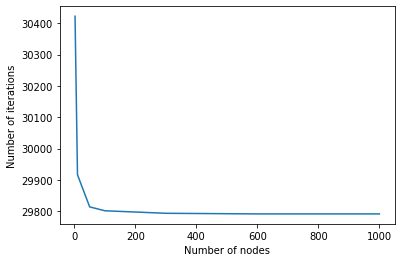

data/nonconvex_dense.npy


In [5]:
topology = "dense"
lr = 1e-1
threshold = 1e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 13.68575382232666
Converged within 0.001 in 30430.8 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 13.301653146743774
Converged within 0.001 in 29910.2 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 15.654550075531006
Converged within 0.001 in 29813.8 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 18.717748165130615
Converged within 0.001 in 29803.4 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 42.37614893913269
Converged within 0.001 in 29795.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 112.2136070728302
Converged within 0.001 in 29792.6 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 264.27600264549255
Converged within 0.001 in 29792.0 iterations on average.



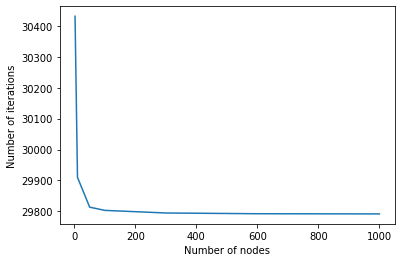

data/nonconvex_ring.npy


In [6]:
topology = "ring"
lr = 1e-1
threshold = 1e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 14.029358863830566
Converged within 0.001 in 30447.8 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 13.19857406616211
Converged within 0.001 in 29922.2 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 15.637509107589722
Converged within 0.001 in 29815.6 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 18.733776092529297
Converged within 0.001 in 29804.8 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 43.439895153045654
Converged within 0.001 in 29795.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 118.82176518440247
Converged within 0.001 in 29794.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 267.79574275016785
Converged within 0.001 in 29792.8 iterations on average.



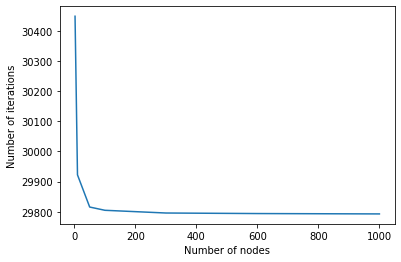

data/nonconvex_centralized.npy


In [7]:
topology = "centralized"
lr = 1e-1
threshold = 1e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Convex function

In [8]:
func_type = "convex"

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 16.807188034057617
Converged within 0.01 in 8376.2 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 34.99093770980835
Converged within 0.01 in 8375.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 123.8746349811554
Converged within 0.01 in 8374.4 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 233.78304409980774
Converged within 0.01 in 8374.2 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 794.8965640068054
Converged within 0.01 in 8374.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 1579.3844258785248
Converged within 0.01 in 8374.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 2627.510699033737
Converged within 0.01 in 8374.0 iterations on average.



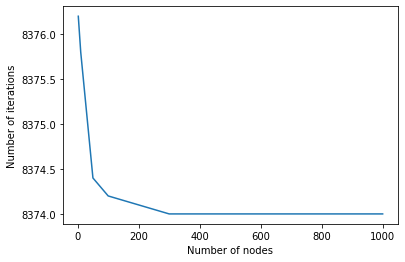

data/convex_dense.npy


In [9]:
topology = "dense"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 25.651336908340454
Converged within 0.01 in 13100.4 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 54.4855318069458
Converged within 0.01 in 13098.4 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 193.311781167984
Converged within 0.01 in 13098.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 364.6778748035431
Converged within 0.01 in 13098.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 1224.7800388336182
Converged within 0.01 in 13098.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 2468.197126865387
Converged within 0.01 in 13097.6 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 4157.85467171669
Converged within 0.01 in 13098.0 iterations on average.



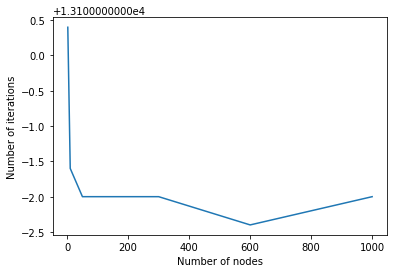

data/convex_ring.npy


In [10]:
topology = "ring"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

In [11]:
topology = "centralized"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 37.298282861709595
Converged within 0.01 in 19075.6 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 79.45951819419861
Converged within 0.01 in 19068.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 281.58321380615234
Converged within 0.01 in 19068.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 530.9267902374268
Converged within 0.01 in 19068.4 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 1738.0967559814453
Converged within 0.01 in 19068.0 iterations on average.

Starting experiment on 600 nodes.


KeyboardInterrupt: 

## Strongly convex function

In [ ]:
func_type = "convex"

In [ ]:
topology = "dense"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

In [ ]:
topology = "ring"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

In [ ]:
topology = "centralized"
lr = 1e-1
threshold = 1e-2

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)